In [1]:
# Sample the kinegeometric distance posterior - an outline
# CBJ Feb. 2024
# Work in units of kpc, km/s, mas, and mas/yr.

In [2]:
import numpy as np
from scipy.special import gamma, factorial
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
import emcee # https://emcee.readthedocs.io/en/stable/
# Other possible samplers:
# https://pymcmcstat.readthedocs.io/en/latest/
# https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/MetropolisHastings
# https://python4mpia.github.io/fitting_data/Metropolis-Hastings.html - old

import rpy2
from rpy2.robjects.packages import importr, data
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from rpy2.robjects import r

numpy2ri.activate() #activate conversion from R-code to numpy arrays
from astroquery.gaia import Gaia
import math
from zero_point import zpt # need to install gaiadr3-zeropoint
zpt.load_tables()

from metropolis import metrop
from functions import mode_post3 
from scipy import integrate

R[write to console]: data.table 1.13.6 using 12 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: Lade nötiges Paket: bit

R[write to console]: 
Attache Paket: ‘bit’


R[write to console]: The following object is masked from ‘package:data.table’:

    setattr


R[write to console]: The following object is masked from ‘package:base’:

    xor


R[write to console]: Attaching package bit64

R[write to console]: package:bit64 (c) 2011-2017 Jens Oehlschlaegel

R[write to console]: creators: integer64 runif64 seq :

R[write to console]: coercion: as.integer64 as.vector as.logical as.integer as.double as.character as.bitstring

R[write to console]: logical operator: ! & | xor != == < <= >= >

R[write to console]: arithmetic operator: + - * / %/% %% ^

R[write to console]: math: sign abs sqrt log log2 log10

R[write to console]: math: floor ceiling trunc round

R[write to console]: querying: is.integer64 is.vector [is.atomic} [length] format print str

R[write t

In [3]:
# Constants
kfac = 4.740471 # vel[km/s] = kfac * r[kpc] * propm[mas/yr]

In [4]:
# Define functions

# Return the mean (meanTau) [1/(km/s)] and covariance (CovTau) [1/(km/s)^2]
# of the velocity prior 
# Sourced from R-file: call_velocity_prior.R
r_source2 = robjects.r['source']
r_source2('./Rfiles/call_velocity_prior.R')
kinegeo_prior_stats = robjects.globalenv['eval.prior.healpix']

def velpriorparams(dist, healpix):
    # Return the mean (meanTau) [1/(km/s)] and covariance (CovTau) [1/(km/s)^2]
    # of the velocity prior 
    
    vramean_tau, vrasd_tau, vdecmean_tau, vdecsd_tau, cor_tau = kinegeo_prior_stats(p=healpix,r=dist*1e3)  # output is in km/s, takes input in pc
    
    meanTau = np.array([vramean_tau,vdecmean_tau])
    CovTau = np.array([[vrasd_tau**2 ,vrasd_tau * vdecsd_tau *cor_tau], [vrasd_tau*vdecsd_tau*cor_tau,vdecsd_tau**2]])
    
    return meanTau , CovTau

def logdistpriordensity(dist, healpix):
    # Return log (base 10) of the unnormalized distance prior [1/kpc]
    rows_prior_summary = np.loadtxt('prior_summary.csv', delimiter=',',skiprows=1)
    alpha = float(rows_prior_summary[healpix][6])
    beta = float(rows_prior_summary[healpix][7])
    rlen = float(rows_prior_summary[healpix][5])
    
    # convert rlen from pc to kpc 
    rlen = rlen*1e-3

    r = np.where(dist > 0,dist,0)
    prior = 1/gamma((beta+1)/alpha)*alpha/(rlen**(beta+1))*r**beta*np.exp(-((r/rlen)**alpha))
    
    return np.log10(prior)

def logparallaxlikelihood(dist, parallax, parallaxVar):
    # Return log (base 10) of the (normalized) likelhood of the parallax at this distance.
    # parallaxVar is the relevant element of the Cov3 matrix.
    # This is a simple 1D Gaussian density.
    return np.log10(mvn.pdf(parallax,mean=1/dist,cov=parallaxVar))
    
    
def loggeopostdensity(dist, parallax, parallaxVar, healpix):
    # Return the log (base 10) of the unnormalized density of the geometric distance 
    # posterior [1/kpc]  
    # logparallaxlikelihood + logdistpriordensity
    
    return logparallaxlikelihood(dist=dist, parallax=parallax, parallaxVar=parallaxVar) + logdistpriordensity(dist=dist, healpix=healpix)
    
def logQfunc(dist, parallax, propm, Cov3, Cov2, kfac,healpix):
    """
    Implements Equation 8d
    In principle we only need the inverse of a covariance matrix to compute
    an unnormalized Gaussian, in which case we could just pass invCov2 and would
    not need Cov2. But scipy.stats.multivariate_normal doesn't seem to give this option.
    We could pass invCov2 to save inverting it for use in m_v and Cov_v, but it's only
    so just write it out explicitly.

    Parameters
    ----------
    dist:      distance [kpc] scalar
    parallax:  parallax [mas] scalar
    promp:     proper motion [mas/yr] 2-element vector
    Cov3:      full data astrometric covariance matrix [various] 3x3 matrix
    Cov2:      partial data covariance matrix [(mas/yr)^2] 2x2 matrix
    CovTau:    velocity prior covariance matrix [(km/s)^2] 2x2 matrix
    kfac:      constant

    Returns
    -------
    Log (base e) density of Q(r,parallax,promp)
    """
    
    # Compute the inverse of Cov2 (equation 4b)
    # Compute X_mu (equation 4a)
    # Call velpriorparams() to get meanTau and CovTau
    # Invert CovTau
    # Compute logdensity of Q using scipy.stats.multivariate_normal.logpdf
    # See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html
    # - don't forget to multiply by kfac*dist to get Q.
     
    Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
    Sigma_w_w = Cov3[0,0]
    
    X_mu = Sigma_mu_w * Sigma_w_w**(-1) * (parallax-1/dist)
    
    meanTau, CovTau = velpriorparams(dist=dist, healpix=healpix)
    
    N = mvn.pdf(x=meanTau,mean=kfac*dist*(propm-X_mu),cov=kfac**2 * dist**2 * Cov2 + CovTau)
    
    return np.log10(kfac*dist) + np.log10(N)
    
def logkinegeopostdensity(dist, parallax, parallaxVar ,propm, Cov3, Cov2, healpix, kfac):
    # Return the log (base 10) of the (unnormalized) density of the kinegeometric 
    # distance posterior [1/kpc]  
    # logQfunc + loggeopostdensit
    return logQfunc(dist=dist, parallax=parallax, propm=propm, Cov3=Cov3, Cov2=Cov2, kfac=kfac,healpix=healpix)+loggeopostdensity(dist=dist, parallax=parallax, parallaxVar=parallaxVar, healpix=healpix)



In [33]:
# Define data: parallax, prompm, Cov3 (equation 2)
# The parallax should be zero-point corrected.
# Compute (once) Cov2 (equation 4b)

source_id = 3490289711213205632

job = Gaia.launch_job("select top 10 "
                                        "source_id, parallax, parallax_error,phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved,bp_rp,pmra,pmra_error,pmdec, pmdec_error,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr "
                                        "from gaiadr3.gaia_source "
                                        "where source_id={}".format(int(source_id)))
r = job.get_results()

w = float(r['parallax'])
sd_w = float(r['parallax_error'])   

mu_ra = float(r['pmra'])
mu_dec = float(r['pmdec'])
sd_mu_ra = float(r['pmra_error'])
sd_mu_dec = float(r['pmdec_error'])
corr_w_mu_ra = float(r['parallax_pmra_corr'])
corr_w_mu_dec = float(r['parallax_pmdec_corr'])
corr_mu_ra_dec = float(r['pmra_pmdec_corr'])

phot_g_mean_mag = float(r['phot_g_mean_mag'])
nu_eff_used_in_astrometry = float(r['nu_eff_used_in_astrometry'])
pseudocolour = float(r['pseudocolour'])
ecl_lat = float(r['ecl_lat'])
astrometric_params_solved = float(r['astrometric_params_solved'])


source_id = int(r['source_id'])
healpix = math.floor(source_id / (2**(35)*4**(12-5)) )

# zeropoint correction
if astrometric_params_solved == 31 or astrometric_params_solved == 95:    
    if  phot_g_mean_mag == np.nan:
        wzp = -0.017                    
    else:
         wzp = zpt.get_zpt(phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved)             
else: 
    wzp = 0

parallax = w - wzp
parallaxVar = sd_w
propm = np.array([mu_ra,mu_dec])

Cov3 = np.array([[sd_w**2, sd_w*sd_mu_ra*corr_w_mu_ra, sd_w*sd_mu_dec*corr_w_mu_dec],
                 [sd_w*sd_mu_ra*corr_w_mu_ra, sd_mu_ra**2, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec],
                 [sd_w*sd_mu_dec*corr_w_mu_dec, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec, sd_mu_dec**2]])


Sigma_w_w = Cov3[0,0]
Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
Sigma_w_mu = np.array([Cov3[0,1],Cov3[0,2]])
Sigma_mu_mu = np.array([[Cov3[1,1],Cov3[1,2]],
                       [Cov3[2,1],Cov3[2,2]]])


Cov2 = Sigma_mu_mu - np.dot(Sigma_mu_w,np.dot(Sigma_w_w**(-1),Sigma_w_mu))


print('\033[1m' + f'Data for Gaia DR3 {source_id}: ' + '\033[0m')
print('')
print('HEALpixel level 5:',healpix)
print('parallax [mas]',w)
print('Zeropoint [mas]', wzp)
print('Zeropointcorrected parallax w[mas]',parallax)
print('proper motion ra [mas/yr]:',mu_ra)
print('proper motion dec [mas/yr]:',mu_dec)
print('proper motion ra error [mas/yr]:',sd_mu_ra)
print('proper motion dec error [mas/yr]:',sd_mu_dec)
print('parallax - proper motion ra correlation: ',corr_w_mu_ra)
print('parallax - proper motion dec correlation: ',corr_w_mu_dec)
print('proper motion ra-dec correlation: ',corr_mu_ra_dec)

Data for Gaia DR3 3490289711213205632: 

HEALpixel level 5: 6200
parallax [mas] 0.5982380400752496
Zeropoint [mas] -0.011402
Zeropointcorrected parallax w[mas] 0.6096400400752496
proper motion ra [mas/yr]: 3.8943519459022378
proper motion dec [mas/yr]: 0.6259127892169852
proper motion ra error [mas/yr]: 0.6698599457740784
proper motion dec error [mas/yr]: 0.5906122922897339
parallax - proper motion ra correlation:  0.052882660180330276
parallax - proper motion dec correlation:  -0.31380876898765564
proper motion ra-dec correlation:  -0.1987118124961853


/tmp/ipykernel_854309/3098121708.py:26: UserWarning: Warning: converting a masked element to nan.
  pseudocolour = float(r['pseudocolour'])


In [48]:
# Sample logkinegeopostdensity 
# Use an MCMC package. You may need a wrapper function to logkinegeopostdensity so that
# it's argument and return(s) are in the right order/format for the MCMC function.
# Try your Metropolis first.
# Later: maybe try emcee. Probably 4-8 walkers is enough. We'll need to experiment to determine
# how much burnin and how many samples, but I expect around 20-50 and 50-100 is enough
# (depending on the number of walkers). Try initializing the walkers close to the
# median of the geometric posterior, with a standard deviation equal to the (robust)
# standard deviation of that that posterior.

# For testing purposes, you should also directly compute a few different posteriors
# on a dense grid , so as to compare the "true" distribution.

# used mode of EDSD-posterior to initialize metrop algorithm, transform to kpc

Nsamp= 500
Nburnin= 50

rows_prior_summary = np.loadtxt('prior_summary.csv', delimiter=',',skiprows=1)
rlen_EDSD = float(rows_prior_summary[healpix][10])
rInit = float(mode_post3(w=1e-3*parallax,wsd=1e-3*parallaxVar,rlen = rlen_EDSD,retall = False))*1e-3 
rStep = 0.75*rInit*min(1/3, abs(parallaxVar/parallax))

samp = metrop(func=logkinegeopostdensity ,thetaInit= rInit ,Nburnin=Nburnin ,Nsamp=Nsamp,sampleCov=rStep**2 ,parallax=parallax, parallaxVar = parallaxVar,propm=propm, Cov3=Cov3, Cov2=Cov2, healpix=healpix, kfac=kfac)
rSamp = samp[:,1]

/tmp/ipykernel_854309/2095547162.py:91: RuntimeWarning: invalid value encountered in log10
  return np.log10(kfac*dist) + np.log10(N)
/tmp/ipykernel_854309/2095547162.py:40: RuntimeWarning: divide by zero encountered in log10
  return np.log10(mvn.pdf(parallax,mean=1/dist,cov=parallaxVar))
/tmp/ipykernel_854309/2095547162.py:34: RuntimeWarning: divide by zero encountered in log10
  return np.log10(prior)


Distance estimation:

estimated distance [pc] (quantile 0.5): 1.4706634811162518
lower distance limit [pc] (quantile 0.159): 0.9262708691003033
upper distance limit [pc] (quantile 0.841): 2.3456286604056045

MCMC initialization [pc]: 1.1585106340258122
MCMC stepsize [pc]: 0.28962765850645306
MCMC number of burn-in samples: 50
MCMC number of retained iterations: 500



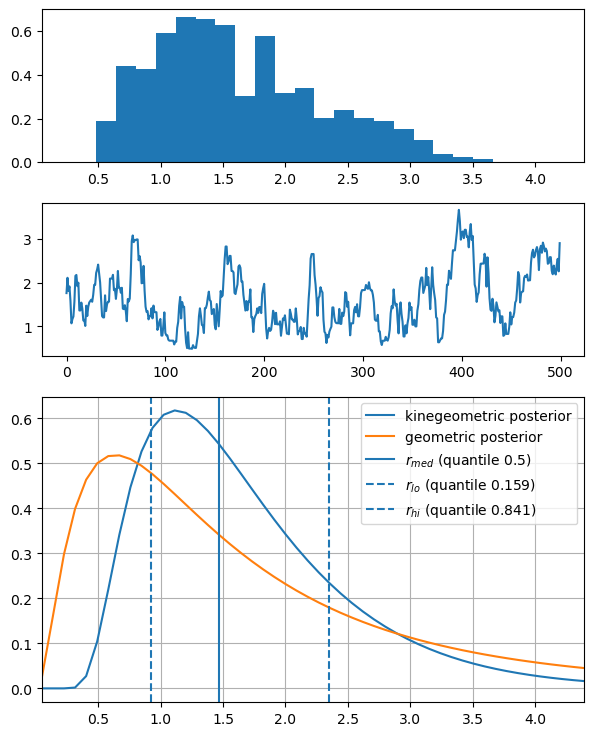

In [49]:
# Plots
fig,ax = plt.subplots(3,1,figsize=(7,9), gridspec_kw={'height_ratios': [1,1,2]})

# distance range for plotting
rplotlo = 0.1*min(rSamp)
rplothi = 1.2*max(rSamp)

r_plot = np.linspace(rplotlo,rplothi)

# plot histogram of samples
ax[0].hist(rSamp,bins=20,density=True)
ax[0].set_xlim(rplotlo,rplothi)

#plot chains
ax[1].plot(np.arange(0,len(rSamp),1),rSamp)

# plot kinegeo + geo posterior              
logKinegeo_plot=[]

for i in r_plot: 
    logKinegeo_plot.append(logkinegeopostdensity(i, parallax, parallaxVar ,propm, Cov3, Cov2, healpix, kfac))

kinegeo_plot = 10**(np.array(logKinegeo_plot))         
kinegeo_norm = integrate.trapezoid(kinegeo_plot,r_plot)

geo_plot = 10**(loggeopostdensity(r_plot, parallax, parallaxVar, healpix))
geo_norm = integrate.trapezoid(geo_plot,r_plot)


ax[2].plot(r_plot,kinegeo_plot/kinegeo_norm, label='kinegeometric posterior')
ax[2].plot(r_plot,geo_plot/geo_norm,label='geometric posterior')

ax[2].set_xlim(rplotlo,rplothi)
ax[2].grid()

# get quantiles: 

probs = np.array([0.5,0.159,0.841])
rQuant = np.quantile(rSamp,probs)
rest = rQuant[0]
rlo = rQuant[1]
rhi = rQuant[2]

ax[2].axvline(rest,label ='$r_{med}$ (quantile 0.5)')
ax[2].axvline(rlo,linestyle='--',label ='$r_{lo}$ (quantile 0.159)')
ax[2].axvline(rhi,linestyle='--',label ='$r_{hi}$ (quantile 0.841)')

ax[2].legend()



print('\033[1m' + 'Distance estimation:' + '\033[0m')
print('')
print('estimated distance [pc] (quantile 0.5):',rest)
print('lower distance limit [pc] (quantile 0.159):', rlo)
print('upper distance limit [pc] (quantile 0.841):', rhi)
print('')
print('MCMC initialization [pc]:', rInit)
print('MCMC stepsize [pc]:',rStep)
print('MCMC number of burn-in samples:',Nburnin)
print('MCMC number of retained iterations:',Nsamp)
print('')

In [50]:
# Other stuff only required for velocity posterior
def logvelpriordensity(vel, dist, healpix):
    # Return log (base 10) density of the velocity prior [1/(km/s)^2] using 
    # scipy.stats.multivariate_normal.logpdf
    # Call velpriorparams(dist, healpix)
    
    meanTau, CovTau = velpriorparams(dist=dist, healpix=healpix)
    N = mvn.pdf(x=vel,mean=meanTau,cov=CovTau)
    
    return np.log10(N)

def velpostparams(dist, parallax, Cov2, Cov3, propm, healpix, kfac): 
    # Return the mean (meanVel) [km/s] and covariance (CovVel) [km/s^2]
    # of the velocity posterior 
    
    meanTau, CovTau = velpriorparams(dist=dist, healpix=healpix)
    invCovTau = np.linalg.inv(CovTau)
    
    Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
    Sigma_w_w = Cov3[0,0]
    
    X_mu = Sigma_mu_w * Sigma_w_w**(-1) * (parallax-1/dist)
    mean2 = propm + X_mu
    
    CovVel = np.linalg.inv(np.linalg.inv(kfac**2 * dist**2 * Cov2) + invCovTau)

    meanVel = np.dot(CovVel , np.dot(np.linalg.inv(kfac**2 * dist**2 * Cov2)*kfac*dist, propm - X_mu )+np.dot(invCovTau,meanTau) )
    
    
    return meanVel, CovVel 


In [51]:
# sample n velocities and take the mean for each kinegeo distance sample

n = 10
Nsamp = len(rSamp)

totVelsamp = [] #mean of velocity samples for all distances
totMeanVel = [] #mean of velocity posterior for all distances 

for i in range(len(rSamp)): 
    
    meanVel, CovVel = velpostparams(dist=rSamp[i], parallax=parallax, Cov2=Cov2, Cov3=Cov3, propm=propm, healpix=healpix, kfac=kfac)
    velsamp = np.random.multivariate_normal(mean = meanVel, cov = CovVel,size = n)
    velsamp_mean = np.mean(velsamp, axis=0)
    totVelsamp.append(velsamp_mean)
    totMeanVel.append(meanVel)
    
    
totVelsamp = np.array(totVelsamp)
totMeanVel = np.array(totMeanVel)

#get results: mean and quantiles of v_ra and v_dec + correlation between array of v_ra and v_dec samples
    
raVel = np.quantile(totVelsamp[:,0], probs)
decVel = np.quantile(totVelsamp[:,1], probs)
corrVel = np.corrcoef(totVelsamp[:,0], totVelsamp[:,1])

# Expectation value of velocity
    
E_v = 1/Nsamp * sum(totMeanVel)

#covariance between each velocity and distance

r_mean = 1/Nsamp * sum(rSamp)

Cov_rv_ra = 1/Nsamp * sum((rSamp-r_mean)*(totMeanVel[:,0]-E_v[0]))
Cov_rv_dec = 1/Nsamp * sum((rSamp-r_mean)*(totMeanVel[:,1]-E_v[1]))



In [54]:
#print summary statistics: 
print('\033[1m' + 'Velocity estimation:' + '\033[0m')
print('')
print('Number of velocity samples drawn for reach of the MCMC distance samples: ',n)
print('')
print('Estimated velocities:')
print('')
print('velocity in ra:')
print('estimated velocity [km/s] (quantile 0.5): ', raVel[0])
print('lower velocity limit [km/s] (quantile 0.159): ',raVel[1])
print('upper velocity limit [km/s](quantile 0.841): ',raVel[2])
print('')
print('velocity in dec:')
print('estimated velocity [km/s] (quantile 0.5): ', decVel[0])
print('lower velocity limit [km/s] (quantile 0.159): ',decVel[1])
print('upper velocity limit [km/s](quantile 0.841): ',decVel[2])
print('')
print('Correlation between v_ra and v_dec: ', corrVel[1,0])
print('')
print('Covariance between each velocity and distance:' )
print('Cov_rv_ra [kpc km/s]: ',Cov_rv_ra )
print('Cov_rv_dec [kpc km/s]: ',Cov_rv_dec )

Velocity estimation:

Number of velocity samples drawn for reach of the MCMC distance samples:  10

Estimated velocities:

velocity in ra:
estimated velocity [km/s] (quantile 0.5):  26.643421725186222
lower velocity limit [km/s] (quantile 0.159):  17.16652262129696
upper velocity limit [km/s](quantile 0.841):  42.46735790023291

velocity in dec:
estimated velocity [km/s] (quantile 0.5):  4.134863075074783
lower velocity limit [km/s] (quantile 0.159):  1.8635914815373684
upper velocity limit [km/s](quantile 0.841):  7.580751719536235

Correlation between v_ra and v_dec:  0.8333389346495422

Covariance between each velocity and distance:
Cov_rv_ra [kpc km/s]:  7.574508188107467
Cov_rv_dec [kpc km/s]:  1.5974890131215282


In [55]:
#ndim, nwalkers = 1, 4
#p0 = np.random.randn(nwalkers, ndim)
#
#sampler = emcee.EnsembleSampler(nwalkers, ndim, logkinegeopostdensity, args=[parallax, parallaxVar ,propm, Cov3, Cov2, healpix, kfac])
#sampler.run_mcmc(p0, 10000)